# <center> 🎤 SER Final Project: Emotion Recognition with EmoDB & RAVDESS </center>

---

## 🧠 **Speech Emotion Recognition (SER)**
### Combining **EmoDB** and **RAVDESS** Datasets for Robust Emotion Analysis

🎯 **Objective:** Build a **Speech Emotion Recognition (SER)** system by leveraging two powerful datasets to improve emotion classification from audio signals.

---

## 🌟 **Project Overview**
This project integrates two widely recognized datasets for speech emotion recognition:

- 🎙 **EmoDB**: Berlin Database of Emotional Speech, featuring German speech samples labeled with emotions.
- 🎼 **RAVDESS**: Ryerson Audio-Visual Database of Emotional Speech and Song, consisting of North American English speech and song recordings.

By combining these datasets, we aim to enhance model performance, ensuring better generalization across different speech samples.

---

## 📊 **Emotion Labels Comparison**

| Dataset  | Emotion Labels                                  |
|----------|-----------------------------------------------|
| **EmoDB** | Neutral, Boredom, Happy, Sad, Angry, Fear, Disgust |
| **RAVDESS** | Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, Surprised |

### 🔹 **Detailed Emotion Mapping:**
#### 📌 **EmoDB Emotion Labels:**
- 😠 **Anger** (Ärger - Wut)
- 😴 **Boredom** (Langeweile)
- 🤢 **Disgust** (Ekel)
- 😨 **Fear** (Angst)
- 😃 **Happiness** (Freude)
- 😢 **Sadness** (Trauer)
- 😐 **Neutral** (Neutral version)

#### 📌 **RAVDESS Emotion Labels:**
- 😐 **Neutral** (01)
- 😌 **Calm** (02)
- 😃 **Happy** (03)
- 😢 **Sad** (04)
- 😠 **Angry** (05)
- 😨 **Fearful** (06)
- 🤢 **Disgust** (07)
- 😲 **Surprised** (08)

In [1]:
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Bidirectional, LSTM, Dense, Attention, Add, Flatten


2025-03-09 15:25:00.894668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#  <center> 🇩🇪 EmoDB </center>

In [2]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("piyushagni5/berlin-database-of-emotional-speech-emodb")
print("Path to dataset files:", path)

# Get list of files
files = [file_path.name for file_path in os.scandir(path+"/wav") if file_path.is_file()]


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1


Emotion Counts:
neutral: 79
disgust: 46
fear: 69
sadness: 62
happiness: 71
anger: 127
boredom: 81


/var/folders/0s/lm29041s6hv5pq_lc3jblq540000gn/T/ipykernel_61150/3749925633.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_order, y=counts, palette="colorblind")


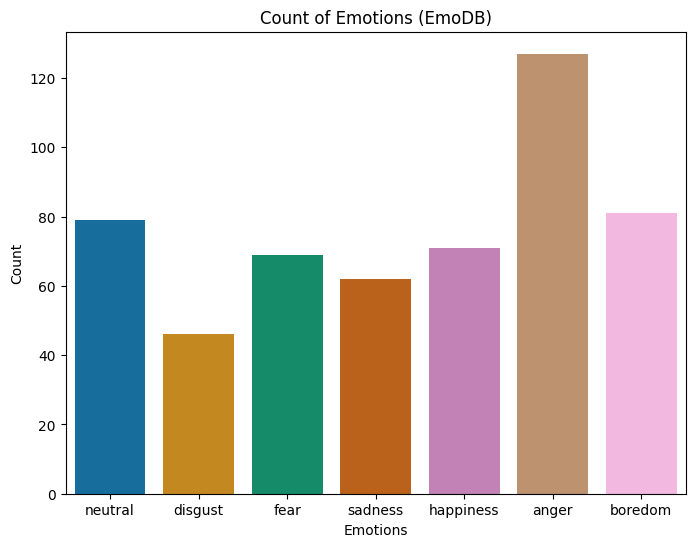

In [3]:
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define the dataset directory
emodb_path = "/Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/*.wav"

# Mapping EmoDB filename encoding to emotions
emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

# Extract emotion labels from filenames
filenames = glob.glob(emodb_path)
emotions = [emotion_map[os.path.basename(f)[5]] for f in filenames if os.path.basename(f)[5] in emotion_map]

# Count occurrences of each emotion
emotion_counts = Counter(emotions)

# Sort emotions by predefined order
emotion_order = ['neutral', 'disgust', 'fear', 'sadness', 'happiness', 'anger', 'boredom']
counts = [emotion_counts[e] for e in emotion_order if e in emotion_counts]

# Print the count of each emotion
print("Emotion Counts:")
for emotion in emotion_order:
    count = emotion_counts.get(emotion, 0)  # Get the count or default to 0 if emotion is not found
    print(f"{emotion}: {count}")

# Plot the emotion distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=emotion_order, y=counts, palette="colorblind")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Count of Emotions (EmoDB)")
plt.show()

In [4]:
import pandas as pd

emo_db = pd.DataFrame({
    'filename': filenames,
    'label': emotions
})
emo_db.head()

filename    label
0  /Users/sofiafernandes/.cache/kagglehub/dataset...  boredom
1  /Users/sofiafernandes/.cache/kagglehub/dataset...    anger
2  /Users/sofiafernandes/.cache/kagglehub/dataset...     fear
3  /Users/sofiafernandes/.cache/kagglehub/dataset...  disgust
4  /Users/sofiafernandes/.cache/kagglehub/dataset...    anger

# <center>🇺🇸 RAVDESS</center>

In [5]:
# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

# Get list of files
files = [file_path.name for file_path in os.scandir(path) if file_path.is_file()]
print(files)

Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
[]


In [6]:
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define the dataset directory
ravdess_path = "/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/**/*.wav"



# Mapping RAVDESS numeric encoding to 🇩🇪 EmoDB Emotions


Emotion Counts:
neutral: 96
calm: 192
happy: 192
sad: 192
angry: 192
fearful: 192
disgust: 192
surprised: 192


/var/folders/0s/lm29041s6hv5pq_lc3jblq540000gn/T/ipykernel_61150/1852842159.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_order, y=counts, palette="colorblind")


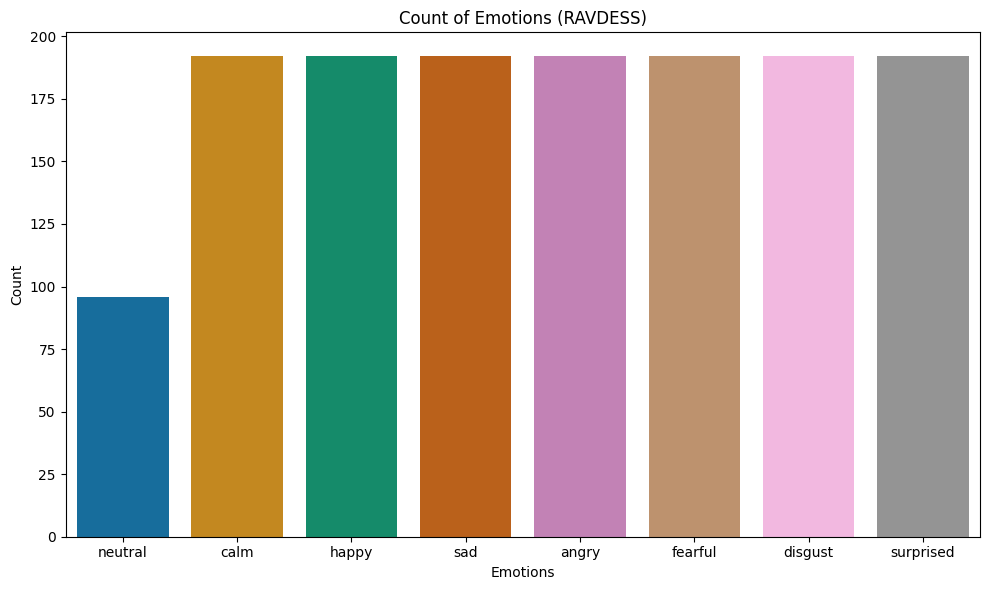

In [7]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Extract emotion labels from filenames
filenames = glob.glob(ravdess_path, recursive=True)
emotions = [emotion_map[os.path.basename(f).split('-')[2]] for f in filenames if os.path.basename(f).split('-')[2] in emotion_map]

# Count occurrences of each emotion
emotion_counts = Counter(emotions)

# Sort emotions by predefined order
emotion_order = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
counts = [emotion_counts[e] for e in emotion_order if e in emotion_counts]

# Print the count of each emotion
print("Emotion Counts:")
for emotion in emotion_order:
    count = emotion_counts.get(emotion, 0)  # Get the count or default to 0 if emotion is not found
    print(f"{emotion}: {count}")

# Plot the emotion distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_order, y=counts, palette="colorblind")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Count of Emotions (RAVDESS)")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [8]:
rav_db = pd.DataFrame({
    'filename': filenames,
    'label': emotions
})
rav_db.head()

filename    label
0  /Users/sofiafernandes/.cache/kagglehub/dataset...    angry
1  /Users/sofiafernandes/.cache/kagglehub/dataset...  fearful
2  /Users/sofiafernandes/.cache/kagglehub/dataset...  fearful
3  /Users/sofiafernandes/.cache/kagglehub/dataset...    angry
4  /Users/sofiafernandes/.cache/kagglehub/dataset...  disgust

# <center> 🧩 Combine 2 Datasets </center>

---

## <center> **Creating a Unified Dataset for Emotion Recognition** </center>

In this section, we will merge two prominent emotion datasets:  
- **RAVDESS** (Ryerson Audio-Visual Database of Emotional Speech and Song)  
- **EmoDB** (Berlin Database of Emotional Speech)

By combining these datasets, we aim to create a comprehensive and diverse dataset that will enhance the performance of our emotion recognition model.

In [9]:
df_paths = pd.concat([rav_db,emo_db], axis = 0)
df_paths.to_csv("data_paths.csv",index=False)

df_paths.tail()

filename      label
530  /Users/sofiafernandes/.cache/kagglehub/dataset...  happiness
531  /Users/sofiafernandes/.cache/kagglehub/dataset...       fear
532  /Users/sofiafernandes/.cache/kagglehub/dataset...    boredom
533  /Users/sofiafernandes/.cache/kagglehub/dataset...    boredom
534  /Users/sofiafernandes/.cache/kagglehub/dataset...       fear

In [10]:
df_paths.reset_index(drop=True)
df_paths.tail()

filename      label
530  /Users/sofiafernandes/.cache/kagglehub/dataset...  happiness
531  /Users/sofiafernandes/.cache/kagglehub/dataset...       fear
532  /Users/sofiafernandes/.cache/kagglehub/dataset...    boredom
533  /Users/sofiafernandes/.cache/kagglehub/dataset...    boredom
534  /Users/sofiafernandes/.cache/kagglehub/dataset...       fear

# <center> 🗑️ Drop Some Categories to Align Labels </center>

---

## <center> **Aligning Emotion Labels Across Datasets** </center>

To ensure consistency between the **RAVDESS** and **EmoDB** datasets, we will streamline the emotion categories by dropping labels that are not shared between the two datasets. 

This step is crucial for creating a **unified set of emotion labels**, which will improve the reliability and accuracy of our emotion recognition model.

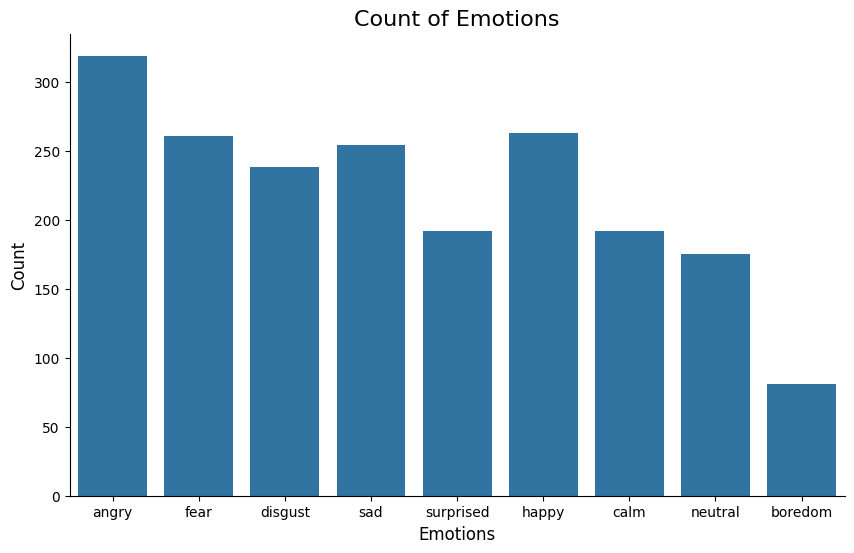

Counter({'angry': 319,
         'fear': 261,
         'disgust': 238,
         'sad': 254,
         'surprised': 192,
         'happy': 263,
         'calm': 192,
         'neutral': 175,
         'boredom': 81})

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections

df_paths['label'] = df_paths['label'].replace({
    'anger': 'angry',
    'happiness': 'happy',
    'sadness': 'sad',
    'fearful' : 'fear'
})

plt.figure(figsize=(10, 6))
# Set the title and labels
plt.title('Count of Emotions', size=16)

# Plot the count of emotions
sns.countplot(x=df_paths['label'])  # Use x= to specify the column

# Add axis labels
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Remove unnecessary spines
sns.despine(top=True, right=True, left=False, bottom=False)

# Display the plot
plt.show()
collections.Counter(df_paths['label'])

# <center> 📊 Visualization of Audio Features for Emotion Analysis </center>

---

## <center> **Exploring Audio Characteristics Across Emotions** </center>

In this section, we delve into the audio features of our dataset to gain insights into how different emotions are represented in the audio signals. By visualizing waveforms, spectrograms, and Mel-Frequency Cepstral Coefficients (MFCCs), we aim to understand the unique characteristics of each emotion.

---

### <center> **Why Visualize Audio Features?** </center>

- **Waveform**: Provides a time-domain view of the audio signal, showing amplitude variations over time.
- **Spectrogram**: Offers a frequency-domain perspective, revealing how the intensity of different frequencies changes over time.
- **MFCCs**: Capture the spectral envelope of the audio, mimicking human perception and serving as a compact representation for machine learning models.

These visualizations help us:
- Identify patterns specific to each emotion.
- Validate the quality of the data.
- Gain intuition about how audio features can be used for emotion recognition.

---

### <center> **Visualization Workflow** </center>

For each emotion in the dataset, we perform the following steps:

1. **Select an Audio Sample**:
   - Filter the dataset for the target emotions.
   - Load the corresponding audio file using `librosa`.

2. **Generate Waveform**:
   - Plot the waveform to observe amplitude changes over time.
   - Example: A steady waveform with minimal fluctuations may indicate a calm or neutral emotion.

3. **Generate Spectrogram**:
   - Compute the Short-Time Fourier Transform (STFT) to analyze the frequency content of the audio.
   - Visualize the spectrogram to identify dominant frequencies and their temporal evolution.
   - Example: Voiced sounds appear as bright vertical bands, while silence or unvoiced sounds appear as dark regions.

4. **Generate MFCCs**:
   - Extract MFCCs to represent the spectral envelope of the audio.
   - Visualize the MFCCs to observe how the coefficients vary over time.
   - Example: MFCCs provide a compact representation that captures the most relevant features for emotion classification.

5. **Play the Audio**:
   - Use the `Audio` function to listen to the selected sample and correlate the sound with its visual representation.

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveform for audio with emotion {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft performs Fourier transform.
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with emotion {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

def create_mfcc(data, sr, e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12, 3))
    plt.title('Mel-frequency cepstral coefficient for audio with emotion {}'.format(e), size=15)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

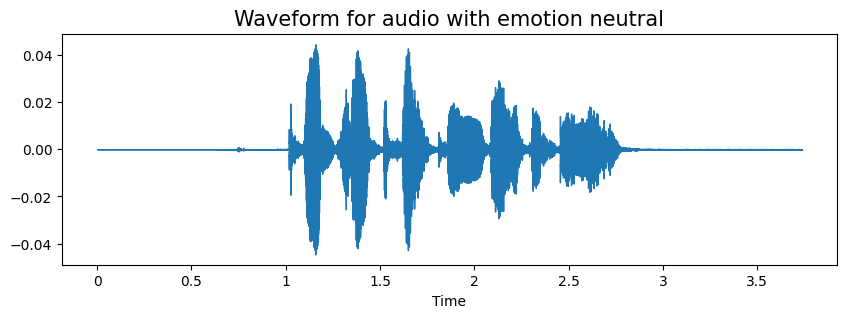

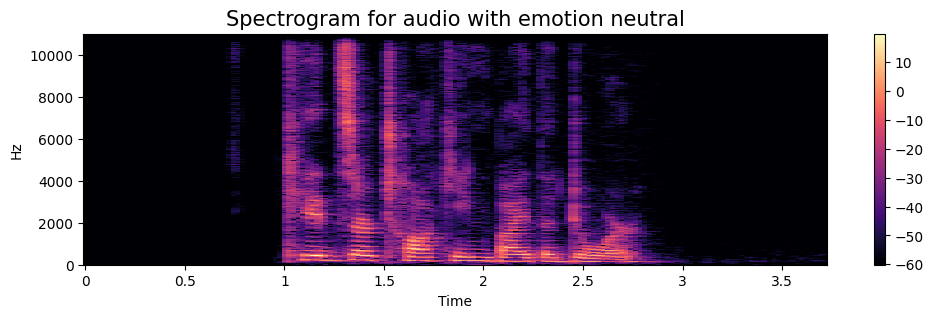

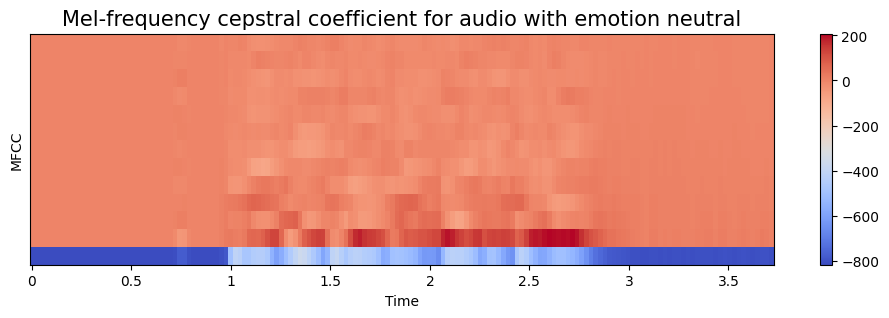

In [13]:

emotion = 'neutral'
path = np.array(df_paths.filename[df_paths.label == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

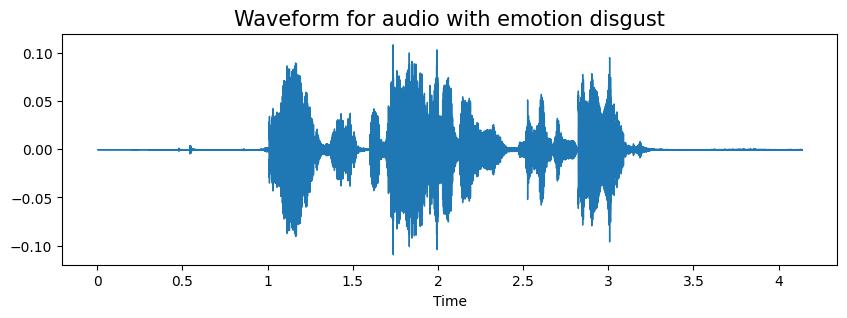

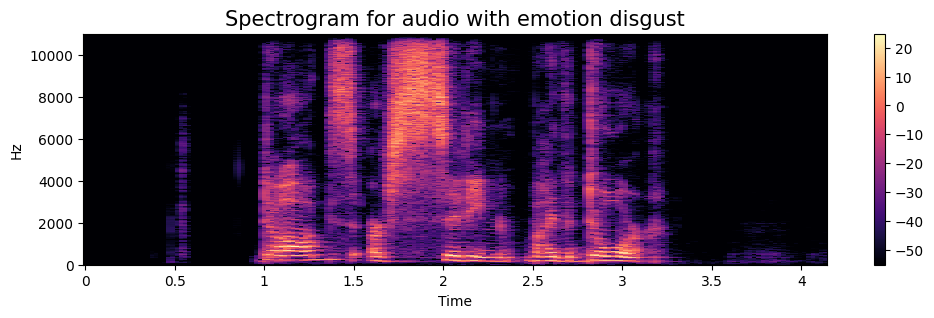

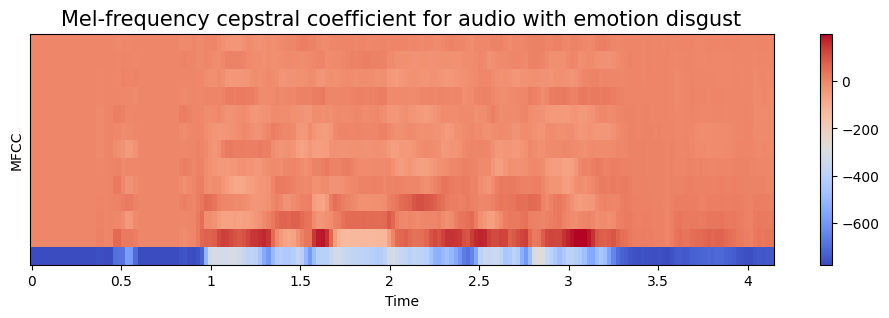

In [14]:
emotion = 'disgust'
path = np.array(df_paths.filename[df_paths.label == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

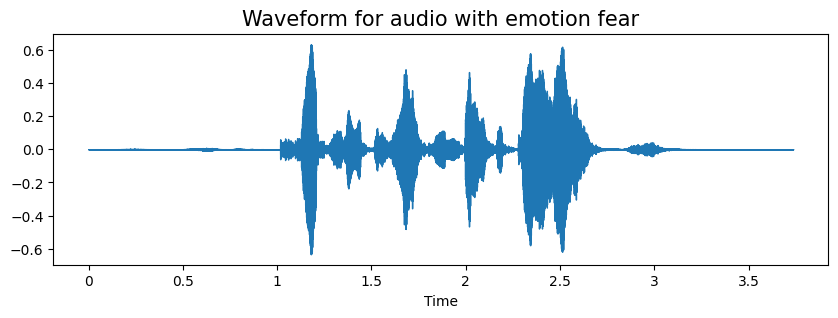

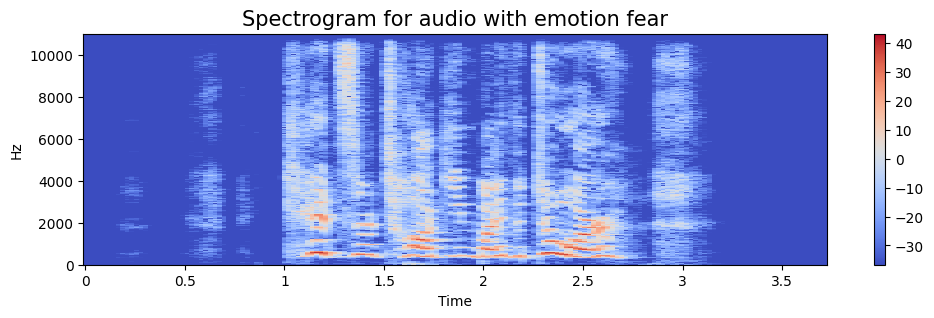

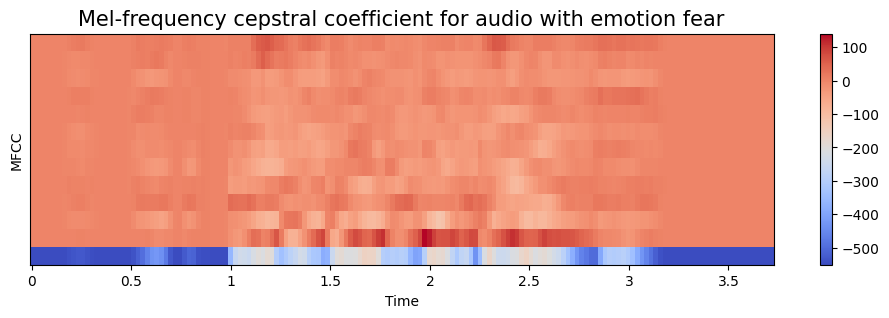

In [15]:
emotion = 'fear'
path = np.array(df_paths.filename[df_paths.label == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

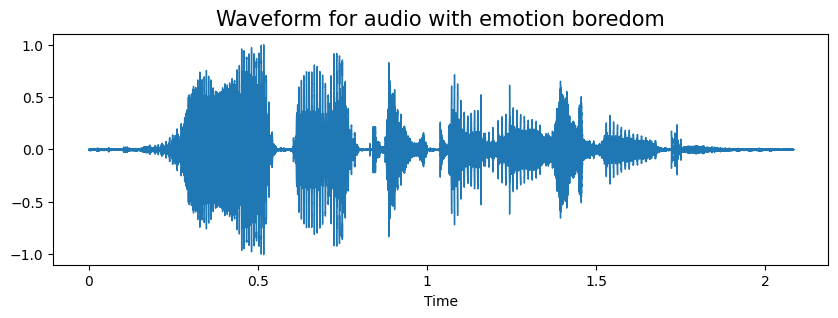

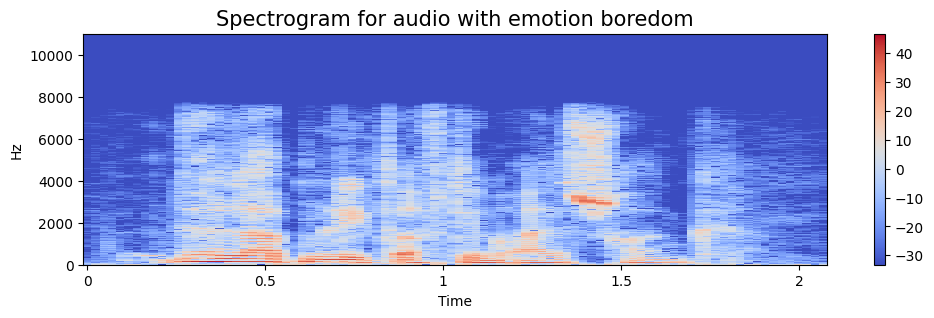

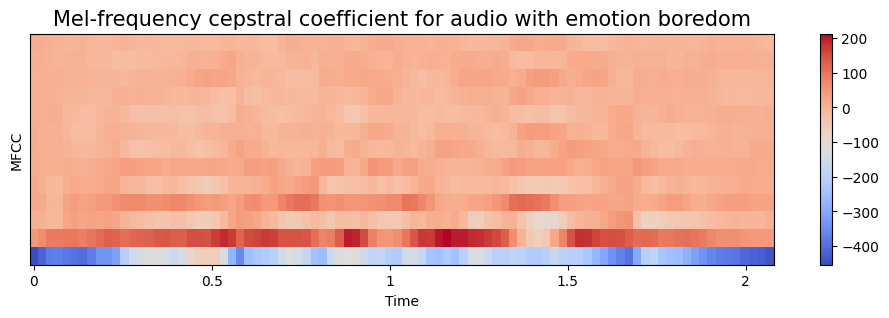

In [16]:
emotion = 'boredom'
path = np.array(df_paths.filename[df_paths.label == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

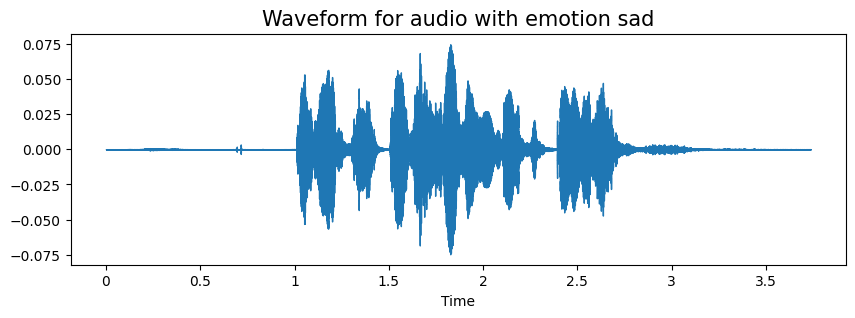

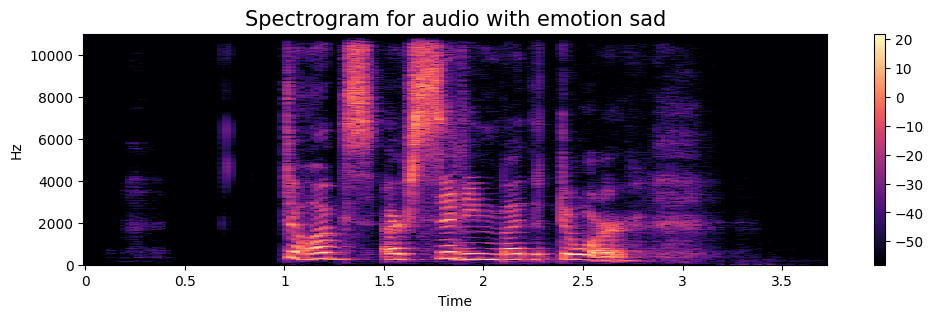

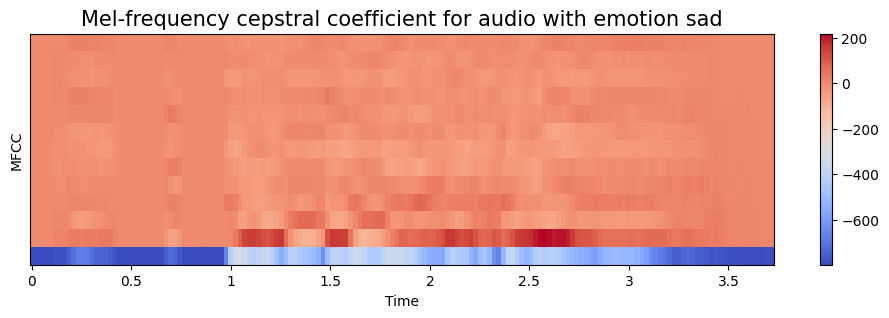

In [17]:
emotion = 'sad'
path = np.array(df_paths.filename[df_paths.label == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

# 🎵 Data Augmentations

In this section, we explore various data augmentation techniques to enhance the diversity of our audio dataset. These augmentations simulate real-world variations in audio signals, making our emotion recognition model more robust and generalizable.

Each augmentation is visualized and explained below:



In [18]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define augmentation functions
def noise(data, noise_rate=0.05):
    noise_amp = noise_rate * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Load an example audio file
path = np.array(df_paths.filename)[2]
data, sample_rate = librosa.load(path)

# Apply augmentations
x_stretched = stretch(data)
x_pitch_shifted = pitch_shift(data, sample_rate)

## 1. Normal Sound
- Represents the original, unmodified audio signal.
- No transformations are applied.
- This serves as the baseline for comparison with augmented versions.
- Clean and unaltered waveform.
- Captures the natural characteristics of the audio.

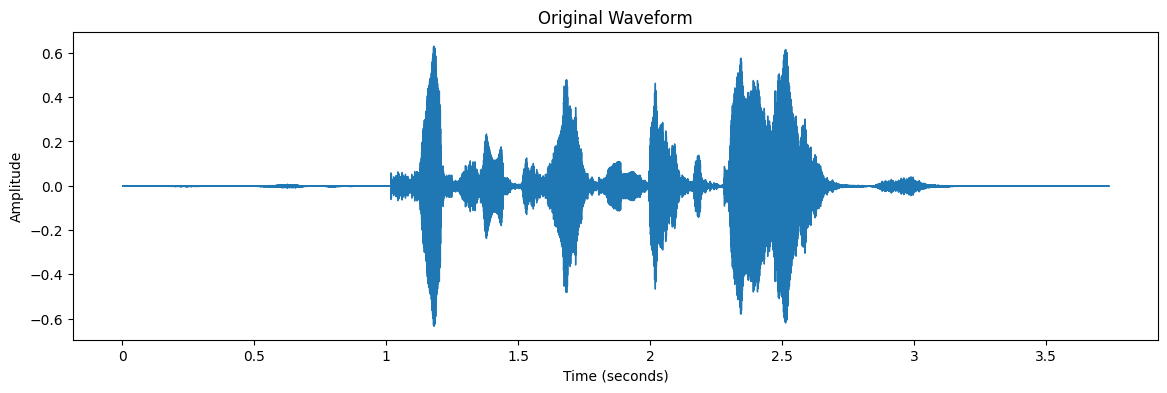

In [19]:
# Plot the original waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Original Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

# Play the original audio
Audio(data, rate=sample_rate)

## 2. Noise Injection 
- Adds random background noise to the audio signal.
- Simulates real-world scenarios where background noise (e.g., traffic, crowd chatter) might be present.
- Helps the model generalize to noisy environments.
- Improves robustness against imperfect audio inputs.

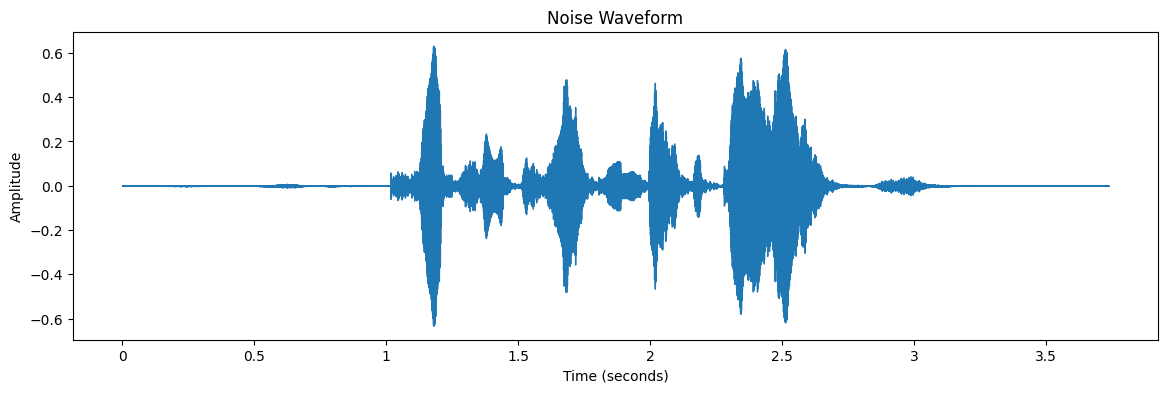

In [20]:
x = noise(data)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Noise Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x, rate=sample_rate)

## 3. Time Stretching
- Stretches or compresses the audio signal without altering its pitch.
- Simulates variations in speaking speed (e.g., faster or slower speech).
- Captures temporal variations in speech patterns.
- Useful for handling speakers who talk at different speeds.

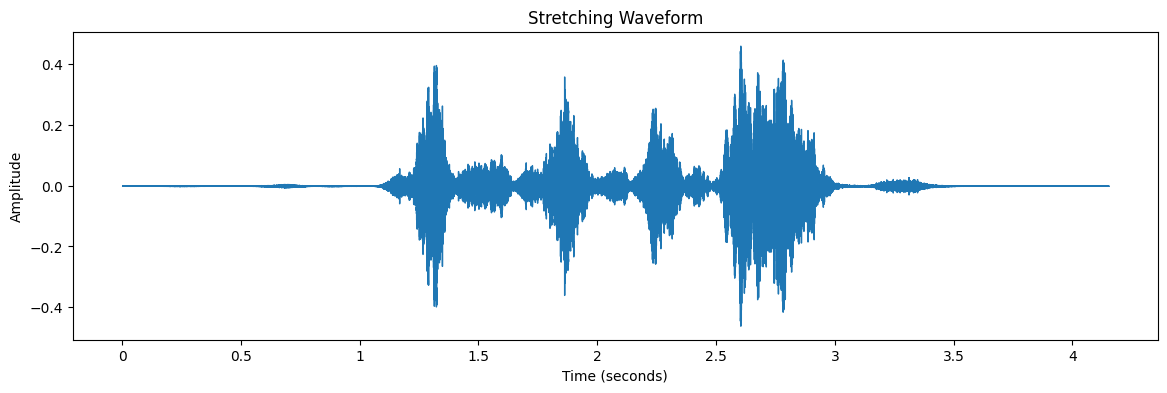

In [21]:
x = stretch(data)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the stretched waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x_stretched, sr=sample_rate)
plt.title("Stretching Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x, rate=sample_rate)

## 4. Pitch Shifting 
- Shifts the pitch of the audio signal up or down by a specified number of semitones.
- Simulates variations in vocal tone (e.g., higher-pitched or lower-pitched voices).
- Accounts for differences in speaker gender, age, or emotional intensity.
- Enhances the model's ability to recognize emotions across diverse vocal tones.

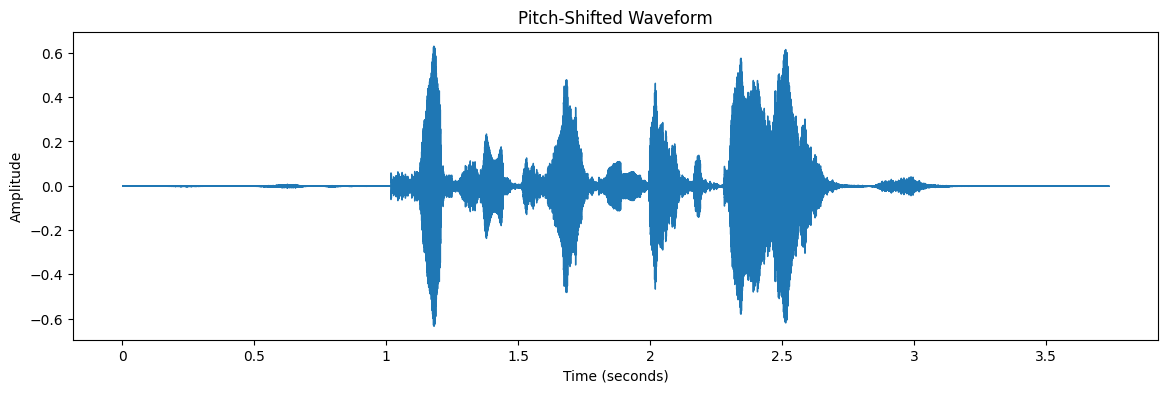

In [22]:
x_pitch_shifted = pitch_shift(data, sample_rate)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Pitch-Shifted Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x_pitch_shifted, rate=sample_rate)

In [23]:
FIXED_LENGTH = 5120  # Adjust this based on your dataset's typical audio length

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# Spectral Centroid
def spectral_centroid(data, sr, n_fft=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return np.squeeze(spectral_centroid)

# MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

# Extract features and stack them into a one-dimensional array
def extract_features(data, sr, frame_length=2048, hop_length=512):
    # Fix the length of the audio signal
    data = librosa.util.fix_length(data, size=FIXED_LENGTH)
    
    # Extract features
    zcr_feature = zcr(data, frame_length, hop_length)
    rmse_feature = rmse(data, frame_length, hop_length)
    spectral_centroid_feature = spectral_centroid(data, sr, frame_length, hop_length)
    mfcc_feature = mfcc(data, sr, frame_length, hop_length)
    
    # Combine features into a single vector
    result = np.hstack((zcr_feature, rmse_feature, spectral_centroid_feature, mfcc_feature))
    return result

In [24]:
# Data augmentation function for the model
def get_features(path):
    # Load audio file
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Normal data
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Noise data
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))
    
    # Stretched data
    stretched_data = stretch(data)
    res3 = extract_features(stretched_data, sample_rate)
    result = np.vstack((result, res3))
    
    # Pitch-shifted data
    pitched_data = pitch_shift(data, sample_rate)
    res4 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res4))
    
    # Combined pitch + noise
    pitched_noise_data = noise(pitched_data)
    res5 = extract_features(pitched_noise_data, sample_rate)
    result = np.vstack((result, res5))
    
    return result

In [25]:
from tqdm import tqdm

X, Y = [], []

with tqdm(zip(df_paths.filename, df_paths.label), 
         total=len(df_paths),
         desc="Processing audio files") as pbar:
    
    for path, emotion in pbar:
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            Y.append(emotion)
        # Optional: Update description with current file being processed
        pbar.set_postfix(file=path.split('/')[-1])

# After processing
X = np.array(X)
Y = np.array(Y)
print(f"\nFinal feature matrix size: {X.shape}")
print(f"Final label array size: {Y.shape}")
print(f"Original file count: {df_paths.filename.shape[0]}")

Processing audio files:   0%|          | 0/1975 [00:00<?, ?it/s]

Processing audio files: 100%|██████████| 1975/1975 [03:14<00:00, 10.17it/s, file=14a05Aa.wav]             



Final feature matrix size: (9875, 253)
Final label array size: (9875,)
Original file count: 1975


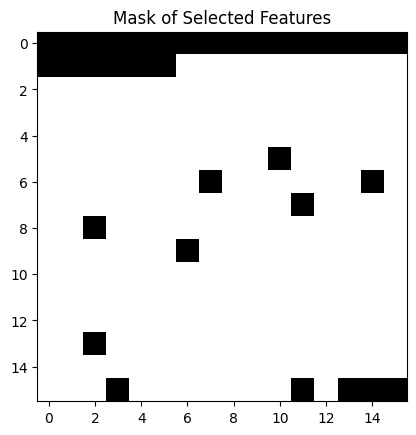

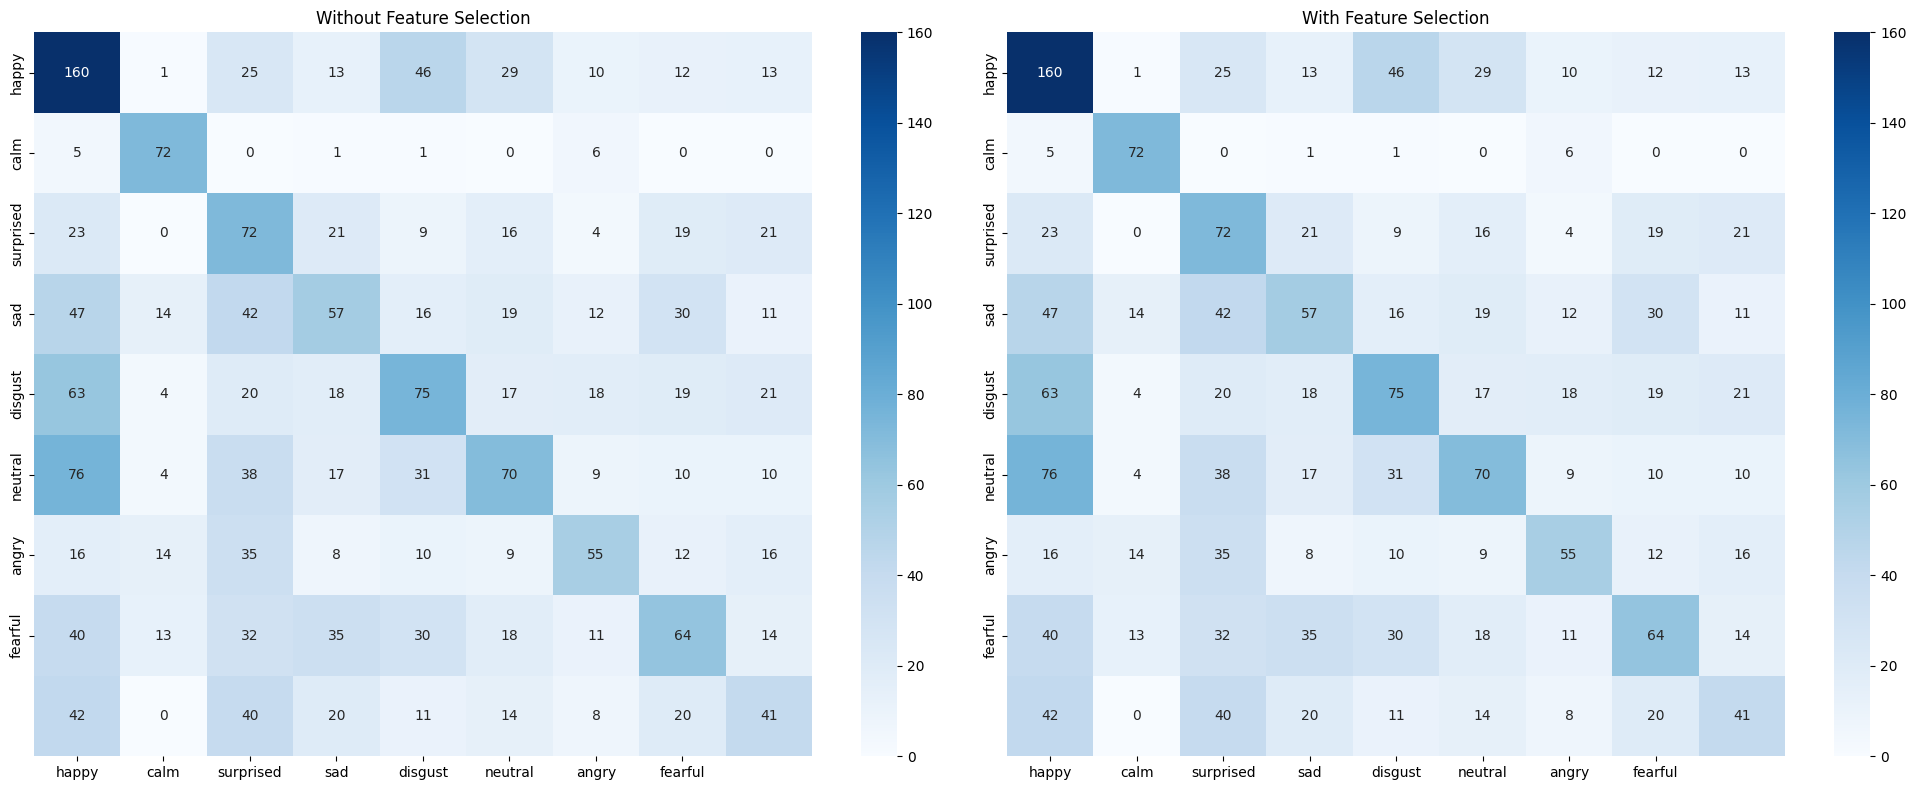


Performance with feature selection:

Final Comparison:
Baseline w/ Selection Accuracy: 33.72%
Reduced Features: 193/253


In [29]:
from select_features import FeatureSelector, algorithm1, algorithm2, plot_feature_mask
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Feature selector
selector = FeatureSelector(algorithm='algorithm1', L=0.88)
selector.fit(X_train)

# Plot mask
n_total_features = X_train.shape[1]
mask = np.zeros(n_total_features)
mask[selector.selected_indices] = 1
plot_feature_mask(mask, 'Mask of Selected Features')

# Apply selection (Algorthm 1)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Normalize features
scaler = StandardScaler()
X_train_sel = scaler.fit_transform(X_train_sel)
X_test_sel = scaler.transform(X_test_sel)

# Apply selection (Algorthm 2)
selector = FeatureSelector(algorithm='algorithm2', L=0.95, MS=0.8)
selector.fit(X_train_sel)
X_train_sel = selector.transform(X_train_sel)
X_test_sel = selector.transform(X_test_sel)

# Train classifier with selected features
clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(X_train_sel, y_train)
sel_pred = clf_selected.predict(X_test_sel)

emotions = set(emotions)

# Comparison
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(confusion_matrix(y_test, sel_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions,
            yticklabels=emotions,
            ax=ax[0])
ax[0].set_title('Without Feature Selection')
sns.heatmap(confusion_matrix(y_test, sel_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions,
            yticklabels=emotions,
            ax=ax[1])
ax[1].set_title('With Feature Selection')
plt.tight_layout()
plt.show()


print("\nPerformance with feature selection:")
#print(classification_report(y_test, sel_pred, target_names=emotions))

# Métricas comparativas
print("\nFinal Comparison:")
print(f"Baseline w/ Selection Accuracy: {accuracy_score(y_test, sel_pred):.2%}")
print(f"Reduced Features: {len(selector.selected_indices)}/{n_total_features}")

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin



pipeline_dl = Pipeline([
    ('selector', FeatureSelector()),
    ('scaler', StandardScaler()),
    ('clf', svm.SVC())
])

param_grid_dl = {
    'selector__L': [0.8, 0.88, 0.93],
    'selector__MS': [0.7, 0.75, 0.8],
    #'clf__input_dim': [X_train.shape[1]]  # Dimensão será ajustada automaticamente
}

grid_dl = GridSearchCV(pipeline_dl, param_grid_dl, cv=3, scoring='accuracy')
grid_dl.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('selector', FeatureSelector()),
                                       ('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'selector__L': [0.8, 0.88, 0.93],
                         'selector__MS': [0.7, 0.75, 0.8]},
             scoring='accuracy')

In [43]:
print("Best parameters:", grid_dl.best_params_)
print("Best score:", grid_dl.best_score_)
results = grid_dl.cv_results_
print("All Results:")
for i in range(len(results['params'])):
    print(f"Parameters: {results['params'][i]}")
    print(f"Mean Test Score: {results['mean_test_score'][i]:.4f}")
    print(f"Std Test Score: {results['std_test_score'][i]:.4f}")
    print(f"Rank: {results['rank_test_score'][i]}")
    print("-" * 20)

Best parameters: {'selector__L': 0.8, 'selector__MS': 0.8}
Best score: 0.4806331510875294
All Results:
Parameters: {'selector__L': 0.8, 'selector__MS': 0.7}
Mean Test Score: 0.4739
Std Test Score: 0.0030
Rank: 7
--------------------
Parameters: {'selector__L': 0.8, 'selector__MS': 0.75}
Mean Test Score: 0.4765
Std Test Score: 0.0039
Rank: 4
--------------------
Parameters: {'selector__L': 0.8, 'selector__MS': 0.8}
Mean Test Score: 0.4806
Std Test Score: 0.0015
Rank: 1
--------------------
Parameters: {'selector__L': 0.88, 'selector__MS': 0.7}
Mean Test Score: 0.4739
Std Test Score: 0.0030
Rank: 7
--------------------
Parameters: {'selector__L': 0.88, 'selector__MS': 0.75}
Mean Test Score: 0.4765
Std Test Score: 0.0039
Rank: 4
--------------------
Parameters: {'selector__L': 0.88, 'selector__MS': 0.8}
Mean Test Score: 0.4806
Std Test Score: 0.0015
Rank: 1
--------------------
Parameters: {'selector__L': 0.93, 'selector__MS': 0.7}
Mean Test Score: 0.4739
Std Test Score: 0.0030
Rank: 7
--

In [ ]:
feat_df = pd.DataFrame(X)
feat_df['label'] = Y
#X = feat_df.drop('label', axis=1)
#Y = feat_df['label'].values
feat_df.to_csv('features.csv', index=False)
print(feat_df.head(10))

feat_df = pd.read_csv('features.csv')
print(feat_df.shape)

          0         1         2         3         4         5         6  \
0  0.000000  0.051758  0.257812  0.450195  0.645996  0.669434  0.463379   
1  0.237305  0.361328  0.481445  0.484375  0.490234  0.491699  0.496094   
2  0.195312  0.271484  0.334473  0.309082  0.295410  0.282227  0.323242   
3  0.197754  0.273438  0.338867  0.312012  0.283691  0.294434  0.339355   
4  0.251465  0.374023  0.499023  0.490234  0.501953  0.506836  0.510742   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.245605  0.367676  0.497559  0.493164  0.497070  0.497559  0.490723   
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9  0.255371  0.378418  0.507324  0.498047  0.500488  0.507812  0.500977   

          7         8         9  ...       244       245       246       247  \
0  0.270996  0.211914  0.136719  ...  0.000000  0.000000  0.000000  0.000000   
1  0.499023  0

Data preparation After extracting features and enhancing data, the next step is to standardize and divide the data set. Here, we divide it into 3 sets: test, validation and train. The OneHotEncoder function is used to encode the label values.

In [ ]:
from sklearn.model_selection import train_test_split


# Split the data into 90% (training + validation) and 10% testing
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=30, shuffle=True, stratify=Y
)

# Split the 90% portion into 80% training and 10% validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1111, random_state=30, shuffle=True, stratify=y_train_val
)

# Check the shapes of the resulting datasets
print("Shapes:")
print("Training set:", x_train.shape )
print("Validation set:", x_val.shape)
print("Testing set:", x_test.shape)



Shapes:
Training set: (7899, 253)
Validation set: (988, 253)
Testing set: (988, 253)


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from src.select_features import algorithm1, algorithm2, FeatureSelector
import matplotlib.pyplot as plt
import numpy as np

# Simple SVM classifier
clf_baseline = svm.SVC(kernel='linear')
clf_baseline.fit(x_train, y_train)
base_pred = clf_baseline.predict(x_test)
print(classification_report(y_test, base_pred, target_names=emotions))
    


In [ ]:
# Use MinMaxScaler for normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)



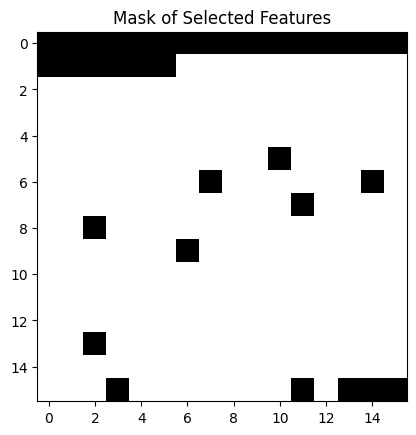

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 253, 512)          3072      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 127, 512)          0         
 g1D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 127, 512)          2048      
 chNormalization)                                                
                                                                 
 dropout_34 (Dropout)        (None, 127, 512)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 127, 256)          655616    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 64, 256)         

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Feature selector
selector = FeatureSelector(algorithm='algorithm1', L=0.88)
selector.fit(X_train)

# Plot mask
n_total_features = X_train.shape[1]
mask = np.zeros(n_total_features)
mask[selector.selected_indices] = 1
plot_feature_mask(mask, 'Mask of Selected Features')

# Apply selection (Algorthm 1)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Normalize features
scaler = StandardScaler()
X_train_sel = scaler.fit_transform(X_train_sel)
X_test_sel = scaler.transform(X_test_sel)

# Apply selection (Algorthm 2)
selector = FeatureSelector(algorithm='algorithm2', L=0.95, MS=0.8)
selector.fit(X_train_sel)
X_train_sel = selector.transform(X_train_sel)
X_test_sel = selector.transform(X_test_sel)
# Reshape the data to include the channel dimension
#X_train = X_train_sel.reshape(X_train.shape[0], X_train.shape[1], 1)  # Shape: (5285, 242, 1)
#X_test = X_test_sel.reshape(X_test.shape[0], X_test.shape[1], 1)      # Shape: (1510, 242, 1)

# Define the model
model = Sequential()

# First Conv1D Block
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(253, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))



# Third Conv1D Block
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM Layers
model.add(LSTM(128, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(128)) 
model.add(Dropout(0.3))

# Fully Connected Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer (9 classes)
model.add(Dense(1, activation='softmax'))  # Assuming 6 emotion classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

In [58]:
# Dynamically generate the epochs array based on the training history
epochs = [i for i in range(len(history.history['loss']))]

# Create subplots
fig, ax = plt.subplots(1, 2)

# Extract metrics from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Set figure size
fig.set_size_inches(20, 6)

# Plot Training & Testing Loss
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

# Plot Training & Testing Accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

# Show the plots
plt.show()

NameError: name 'history' is not defined

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

model_name = 'SER_model_0.69.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)